# Word2Vec and LDA
https://www.kaggle.com/code/jl18pg052/word-embedding-word2vec-topic-modelling-lda

### Extracting informations from Text using Text Mining Techniques

Import Libraries

In [68]:
import pandas as pd
import numpy as np
import re, nltk
import spacy
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nlp = spacy.load('en_core_web_sm')

from tqdm import tqdm
from sklearn.manifold import TSNE
from collections import Counter
from matplotlib.ticker import FuncFormatter
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from gensim import corpora
from gensim.models import Word2Vec
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Import `module_details_labelled.csv` Dataset

In [69]:
data = pd.read_csv("module_details_labelled.csv")
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,School,Major,Course_Code,Course_Name,Course_Description,Prereq,Category
0,NUS,Data Science and Analytics,DSA1101,Introduction to Data Science,The abundance of data being harvested from var...,"{'or': ['MA1301:D', 'MA1301FC:D', 'MA1301X:D']}",Core
1,NUS,Data Science and Analytics,CS2040,Data Structures and Algorithms,This course introduces students to the design ...,"{'or': ['CS1010:D', 'CS1010E:D', 'CS1010X:D', ...",Core
2,NUS,Data Science and Analytics,DSA2101,Essential Data Analytics Tools: Data Visualisa...,Data visualisation is an essential tool for da...,"{'and': [{'or': ['BT1101:D', 'DSA1101:D', 'DSE...",Core
3,NUS,Data Science and Analytics,DSA2102,Essential Data Analytics Tools: Numerical Comp...,This course aims at introducing basic concepts...,"{'and': [{'or': ['MA1101R:D', 'MA1508E:D', 'MA...",Core
4,NUS,Data Science and Analytics,MA2001,Linear Algebra I,This course is a first course in linear algebr...,"{'or': ['MA1301:D', 'MA1301FC:D', 'MA1301X:D']}",Core


Dataset Description

In [70]:
print(data.columns)
print(len(data.columns))
print(data.shape)
print(data.info())
print(data.isnull().sum())

Index(['School', 'Major', 'Course_Code', 'Course_Name', 'Course_Description',
       'Prereq', 'Category'],
      dtype='object')
7
(530, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   School              530 non-null    object
 1   Major               530 non-null    object
 2   Course_Code         530 non-null    object
 3   Course_Name         530 non-null    object
 4   Course_Description  530 non-null    object
 5   Prereq              297 non-null    object
 6   Category            530 non-null    object
dtypes: object(7)
memory usage: 29.1+ KB
None
School                  0
Major                   0
Course_Code             0
Course_Name             0
Course_Description      0
Prereq                233
Category                0
dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Getting Relevant modules (not part of core curriculum and GE)

In [71]:
core1 = ['Core', 'Elective']
data_core = data.loc[data['Category'].isin(core1)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Text Cleaning

Now let's start the text cleaning process.

In [72]:
class Preprocess:
    def __init__(self, data, sw_removal = False, stem = False, lem = False, ds_vocab = False):
        """
        tokenize: Tokenize the corpus
        sw_removal: Removes stopwords
        stem: Performs Stemming (lem must be False, else neither will be performed)
        lem: Performs Lemmatization (stem must be False, else neither will be performed)
        ds_vocb: Filters domain specific vocab.
            i.e. Words that does not help in comparison of uni courses like "student", "course"
            Adding or removing such words should not make the course description feel different
        """

        self.data = data.copy(deep=True)
        self.sw_removal = sw_removal
        self.stem = stem
        self.lem = lem
        self.ds_vocab = ds_vocab

        # Descriptions are short. So the course name may contain important information as well
        self.data['Course_Description'] = self.data['Course_Name'] + " " + self.data['Course_Description']

        # Remove line breaks and punctuations.
        self.data['Course_Description'] = self.data['Course_Description'].apply(lambda sentence: re.sub('\n', ' ',sentence))
        self.data['Course_Description'] = self.data['Course_Description'].apply(lambda sentence: re.sub(r'[^\w\s]', '',sentence))

        # Lowercase everything
        self.data['Course_Description'] = self.data['Course_Description'].apply(lambda sentence: sentence.lower())

        # Tokenization
        self.data['Course_Description'] = self.data['Course_Description'].apply(lambda sentence: word_tokenize(sentence))

        # Remove stopwords
        if self.sw_removal:
            stop_words = set(stopwords.words('english'))
            self.data['Course_Description'] = self.data['Course_Description'].apply(lambda sentence: [word for word in sentence if not word in stop_words])

        # Stemming
        if self.stem:
            if not self.lem:
                ps = PorterStemmer()
                self.data['Course_Description'] = self.data['Course_Description'].apply(lambda sentence: [ps.stem(word) for word in sentence])

        # Lemmatization
        if self.lem:
            if not self.stem:
                lemmatizer = WordNetLemmatizer()
                self.data['Course_Description'] = self.data['Course_Description'].apply(lambda sentence: [lemmatizer.lemmatize(word) for word in sentence])

        # Remove not very meaningful words
        if self.ds_vocab:
            unhelpful_words = {"course", "student", "topic", "concept", "also", "skill", "learn", "include", "knowledge", "aim", "study", "use", "using", "understanding", "different", "various", "cover", "understand", "provide", "able", "eg", "example"}
            self.data['Course_Description'] = self.data['Course_Description'].apply(lambda sentence: [word for word in sentence if not word in unhelpful_words])

        self.data['Course_Description'] = self.data['Course_Description'].apply(lambda sentence: ' '.join(sentence))

    def get_tagged_data(self, ngram_max = 2, tokens_only=False):  # For doc2vec. Return tagged data for training and tokens only for inference
        def process_sentence(sentence):
            output = []
            for i in range(1, ngram_max + 1):  # Apply ngram for n = 1,2,3...
                output += [" ".join(words) for words in ngrams(word_tokenize(sentence), n=i)]
            return output

        if tokens_only:
            return self.data.apply(lambda row:process_sentence(row["Course_Description"]), axis=1)
        return self.data.apply(lambda row:TaggedDocument(words=process_sentence(row["Course_Description"]), tags=[row.name]), axis=1)

    def count_vec(self, ngram_range = (1,1), max_features = None):
        count_vec = CountVectorizer(ngram_range = ngram_range, max_features = max_features)
        return count_vec.fit_transform(self.data["Course_Description"]).toarray()

    def tfidf(self, ngram_range = (1,1), max_features = None):
        tfidf = TfidfVectorizer(ngram_range = ngram_range, max_features = max_features)
        return tfidf.fit_transform(self.data["Course_Description"]).toarray()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perform data preprocessing on `data_core`

In [73]:
preprocessor  = Preprocess(data_core, sw_removal=True, ds_vocab= True, lem=True)
data_core["lemmatize_joined"] = preprocessor.get_tagged_data(ngram_max=2, tokens_only=True)
data_core.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-73-dff03061f5a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_core["lemmatize_joined"] = preprocessor.get_tagged_data(ngram_max=2, tokens_only=True)


,School,Major,Course_Code,Course_Name,Course_Description,Prereq,Category,lemmatize_joined
0,NUS,Data Science and Analytics,DSA1101,Introduction to Data Science,The abundance of data being harvested from var...,"{'or': ['MA1301:D', 'MA1301FC:D', 'MA1301X:D']}",Core,"[introduction, data, science, abundance, data,..."
1,NUS,Data Science and Analytics,CS2040,Data Structures and Algorithms,This course introduces students to the design ...,"{'or': ['CS1010:D', 'CS1010E:D', 'CS1010X:D', ...",Core,"[data, structure, algorithm, introduces, desig..."
2,NUS,Data Science and Analytics,DSA2101,Essential Data Analytics Tools: Data Visualisa...,Data visualisation is an essential tool for da...,"{'and': [{'or': ['BT1101:D', 'DSA1101:D', 'DSE...",Core,"[essential, data, analytics, tool, data, visua..."
3,NUS,Data Science and Analytics,DSA2102,Essential Data Analytics Tools: Numerical Comp...,This course aims at introducing basic concepts...,"{'and': [{'or': ['MA1101R:D', 'MA1508E:D', 'MA...",Core,"[essential, data, analytics, tool, numerical, ..."
4,NUS,Data Science and Analytics,MA2001,Linear Algebra I,This course is a first course in linear algebr...,"{'or': ['MA1301:D', 'MA1301FC:D', 'MA1301X:D']}",Core,"[linear, algebra, first, linear, algebra, fund..."


### Tokenize Bigrams

In [74]:
# Flatten the list of bigrams into a list of strings
flattened_bigrams = [bigram for sublist in data_core["lemmatize_joined"] for bigram in sublist]

# Tokenize the flattened bigrams
tokens = [nltk.word_tokenize(bigram) for bigram in flattened_bigrams]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Topic Modelling using LDA

The input will be in the form of document-term matrix, and we will convert that using the below piece of code.

In [75]:
lemmatized_stuff = tokens

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
dictionary = corpora.Dictionary(lemmatized_stuff)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in lemmatized_stuff]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Try for a range of topics and narrow down to a smaller range we want to work with based on the coherence score obtained (evaluation metric).

In [77]:
LDA = gensim.models.ldamodel.LdaModel

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [78]:
scores = []
num = []
# Build LDA model
def lda_stuff(i):
  lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=i, random_state=100,
                chunksize=200, passes=100)
  lda_model.print_topics()
  coherence_model_lda = CoherenceModel(model=lda_model,
  texts=lemmatized_stuff, dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  return i, coherence_lda


for i in range(1,10):
  num_val, result_val = lda_stuff(i)
  num += [num_val]
  scores += [result_val]
  print(f"Number of Topics: {num_val} and Coherence Score: {result_val}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of Topics: 1 and Coherence Score: 0.5883054795349504
Number of Topics: 2 and Coherence Score: 0.6416356731263742
Number of Topics: 3 and Coherence Score: 0.6739084545223503
Number of Topics: 4 and Coherence Score: 0.6909336469454359
Number of Topics: 5 and Coherence Score: 0.7058756432887019
Number of Topics: 6 and Coherence Score: 0.7148530410194892
Number of Topics: 7 and Coherence Score: 0.7043148477425499
Number of Topics: 8 and Coherence Score: 0.720598601859908
Number of Topics: 9 and Coherence Score: 0.6955449731107364


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


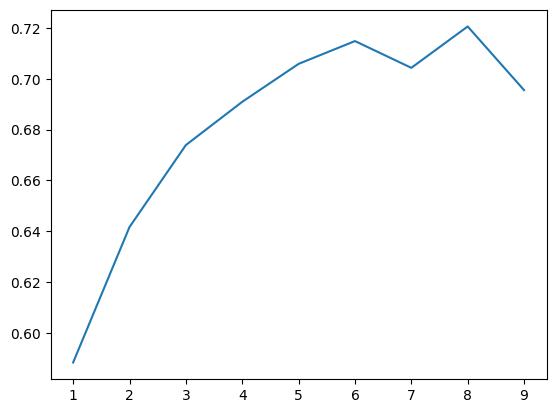

In [79]:
plt.plot(num, scores)

From the line plot above, we can see that 8 has the highest coherence score, followed closely by 6. Since 8 will be too many based on our knowledge as data science students (data science does not comprise this many components), we tried for a range of 3 to 6. In this particular file, we will only be trying with 4 topics.

### Using number of topics = 4



In [80]:
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=4, random_state=100,
                chunksize=200, passes=100)
lda_model.print_topics()
coherence_model_lda = CoherenceModel(model=lda_model,
texts=lemmatized_stuff, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.6909336469454359


### WordClouds for Topics' Keywords

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


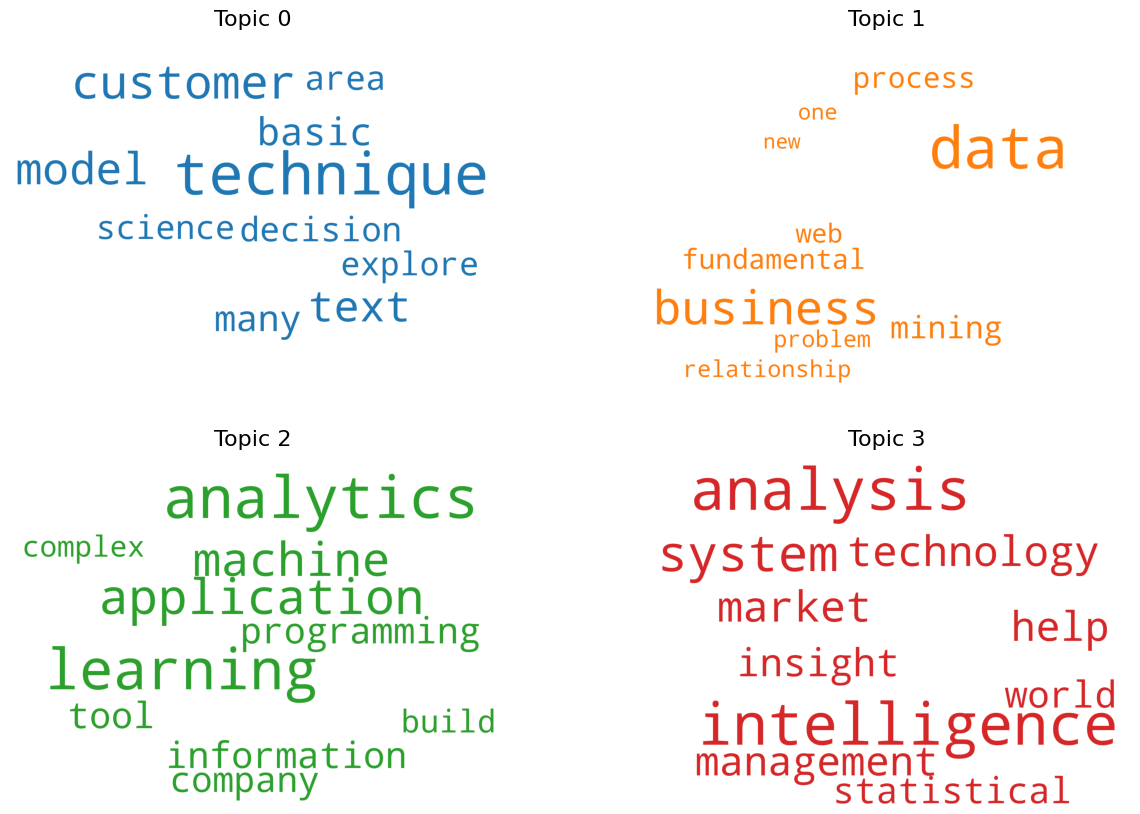

In [81]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(15,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

### Dominant topic for each Document

Using below piece of code we will try to find the dominant topic for each document.

In [82]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=lemmatized_stuff)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Streaming output truncated to the last 5000 lines.
<ipython-input-82-32b5203533b5>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-82-32b5203533b5>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-82-32b5203533b5>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-82-32b5203533b5>:15: FutureWarning: The frame.app

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.6250,"analytics, learning, application, machine, inf...",[introduction]
1,1,1,0.6250,"data, business, mining, process, fundamental, ...",[data]
2,2,0,0.6250,"technique, customer, model, text, basic, many,...",[science]
3,3,0,0.5284,"technique, customer, model, text, basic, many,...",[abundance]
4,4,1,0.6250,"data, business, mining, process, fundamental, ...",[data]
5,5,0,0.5277,"technique, customer, model, text, basic, many,...",[harvested]
6,6,1,0.6250,"data, business, mining, process, fundamental, ...",[sector]
7,7,1,0.6250,"data, business, mining, process, fundamental, ...",[today]
8,8,3,0.6250,"analysis, intelligence, system, market, techno...",[society]
9,9,2,0.6249,"analytics, learning, application, machine, inf...",[increase]


Word count and Importance of Topic Keywords

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-83-6f040cfda922>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


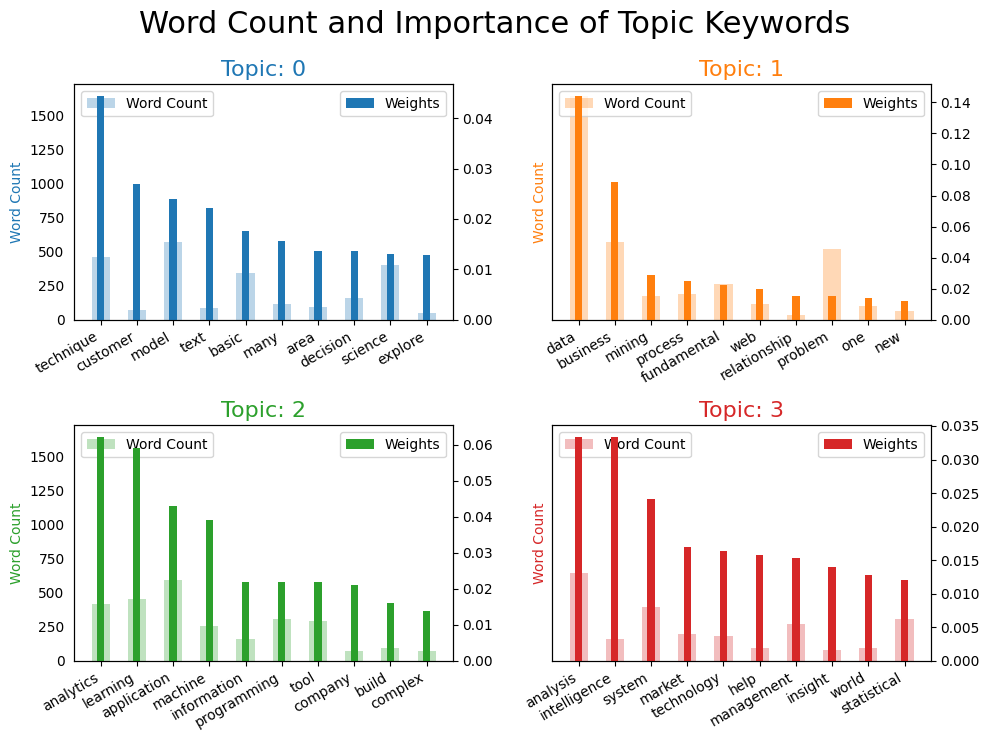

In [83]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in lemmatized_stuff for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(10,7), sharey=True, dpi=100)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

### Word Clouds for each topic

In [84]:
data_core["Dominant Topic"] = df_dominant_topic["Dominant_Topic"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-84-e87f44796d5c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_core["Dominant Topic"] = df_dominant_topic["Dominant_Topic"]


Data Science and Analytics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Text(0.5, 1.0, 'Data Science and Analytics')

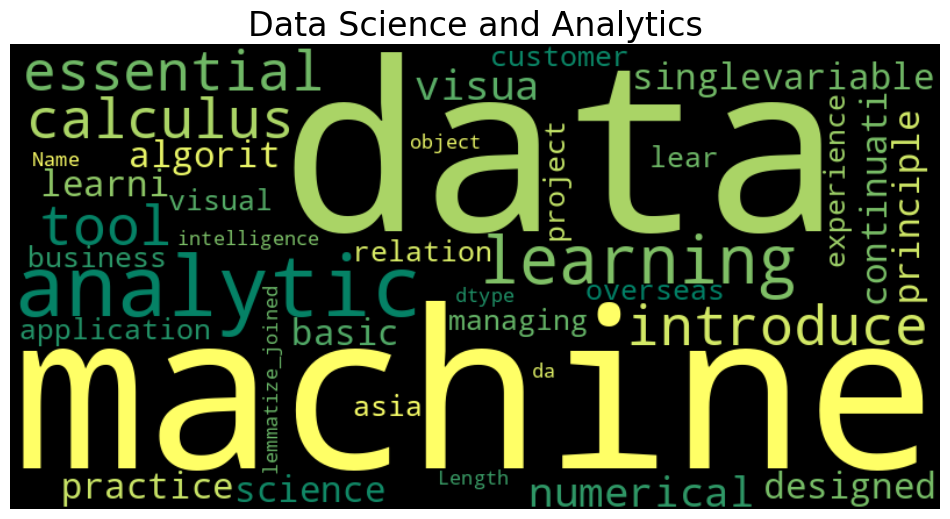

In [93]:
cloud=WordCloud(colormap="summer",width=800,height=400).generate(str(data_core[data_core["Dominant Topic"]==0.0]["lemmatize_joined"]))
fig=plt.figure(figsize=(12,10))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')
plt.title("Data Science and Analytics", size = 24)

Business Analytics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Text(0.5, 1.0, 'Business Analytics')

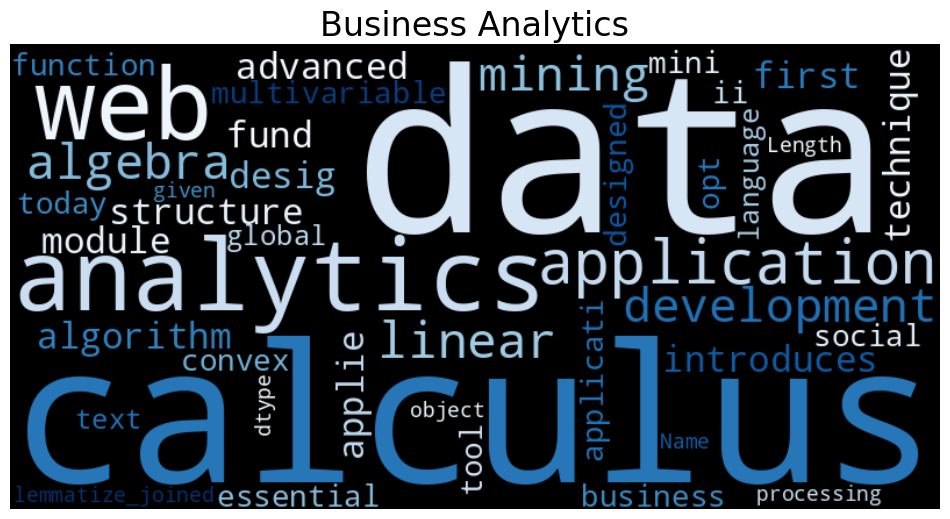

In [94]:
cloud=WordCloud(colormap="Blues",width=800,height=400).generate(str(data_core[data_core["Dominant Topic"]==1.0]["lemmatize_joined"]))
fig=plt.figure(figsize=(12,10))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')
plt.title("Business Analytics", size = 24)

Business Analytics



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Text(0.5, 1.0, 'Business Analytics')

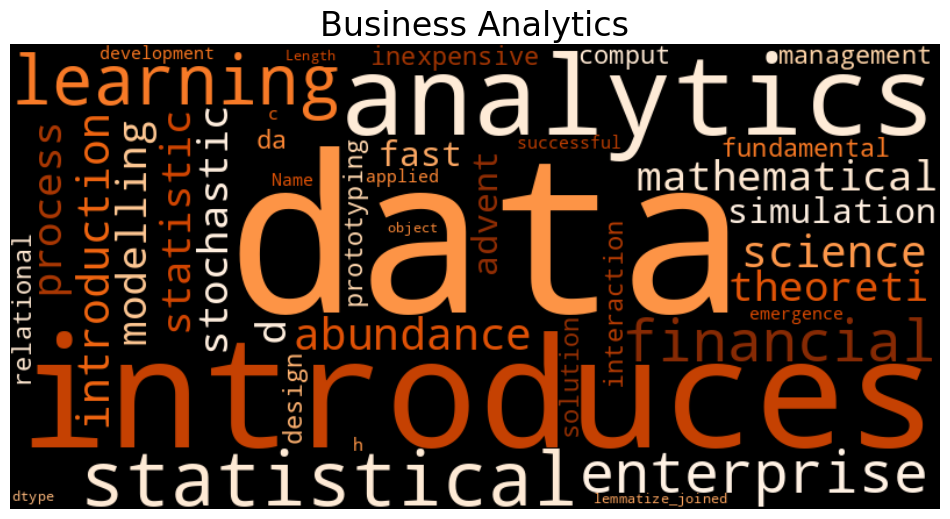

In [92]:
cloud=WordCloud(colormap="Oranges",width=800,height=400).generate(str(data_core[data_core["Dominant Topic"]==2.0]["lemmatize_joined"]))
fig=plt.figure(figsize=(12,10))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')
plt.title("Business Analytics", size = 24)

Data Science


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Text(0.5, 1.0, 'Data Science')

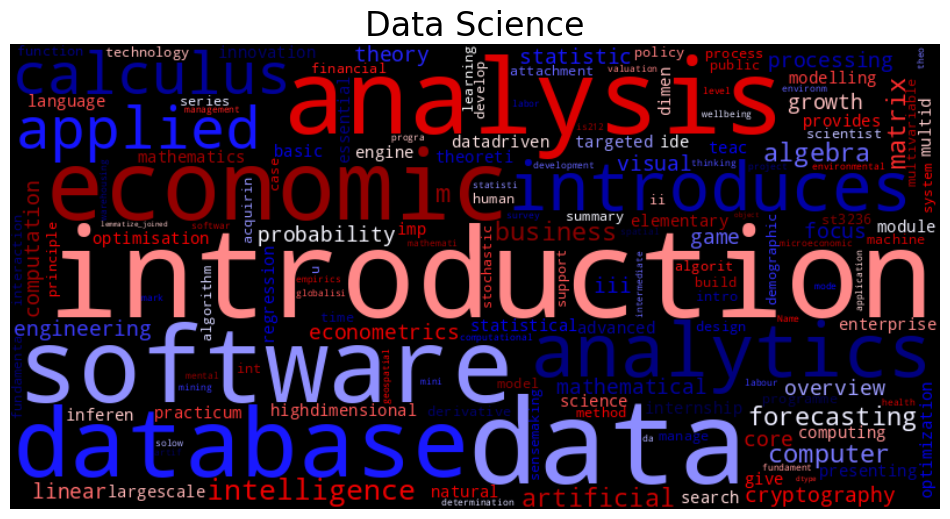

In [95]:
cloud=WordCloud(colormap="seismic",width=800,height=400).generate(str(data_core[data_core["Dominant Topic"]==3.0]["lemmatize_joined"]))
fig=plt.figure(figsize=(12,10))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')
plt.title("Data Science", size = 24)

From the wordclouds above, it is observed that there are overlaps among the different topics. Besides, some topics have keywords which generalise to all of data science and analytics, which is not what we are looking for.

### Most Salient Terms

> Finding out most important/relevant terms associated with each topic in model.



In [89]:
pip install pyLDAvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Using cached pandas-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.3 which is incompatible.


In [90]:
# MUST USE THIS VERSION
!pip install pandas==1.5.3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.3
    Uninstalling pandas-2.1.3:
      Successfully uninstalled pandas-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [106]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis

# Enable notebook mode for pyLDAvis
pyLDAvis.enable_notebook()

# Assuming you have your LDA model, document-term matrix, and dictionary ready
# lda_model, doc_term_matrix, dictionary = ...

# Generate the pyLDAvis visualization directly
LDAvis_prepared = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)

# Display the visualization
LDAvis_prepared

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.057743  0.162160       1        1  25.610905
3     -0.085491  0.239789       2        1  24.868176
1     -0.219404 -0.301740       3        1  24.788161
2      0.362638 -0.100209       4        1  24.732757, topic_info=               Term         Freq        Total Category  logprob  loglift
1              data  2122.000000  2122.000000  Default  30.0000  30.0000
377        business  1307.000000  1307.000000  Default  29.0000  29.0000
69        analytics   914.000000   914.000000  Default  28.0000  28.0000
26         learning   867.000000   867.000000  Default  27.0000  27.0000
171       technique   676.000000   676.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
1011  communication    88.599577    89.352465   Topic4  -5.1094   1.3886
2657       location   114.529857   115.816398   Topic4  -4.8527   1.3859
1027         online   111.220592   112.920742   Topic4  -4.8820   1.3819
1950        massive    91.695413    92.508985   Topic4  -5.0751   1.3882
1191            top    94.562677    99.827461   Topic4  -5.0443   1.3429

[165 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1282      1  0.008112         ai
1282      2  0.981529         ai
1282      4  0.008112         ai
126       1  0.995191    algebra
53        4  0.993942  algorithm
...     ...       ...        ...
651       3  0.989068        way
1035      3  0.998933        web
549       3  0.988061       well
967       3  0.990249    without
586       2  0.996488      world

[152 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

### Determine Topic of New Document (with bigrams)

In [97]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from gensim.models.doc2vec import TaggedDocument
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

class Preprocess:
    def __init__(self, data, sw_removal=False, stem=False, lem=False, ds_vocab=False):
        """
        tokenize: Tokenize the input text
        sw_removal: Removes stopwords
        stem: Performs Stemming (lem must be False, else neither will be performed)
        lem: Performs Lemmatization (stem must be False, else neither will be performed)
        ds_vocab: Filters domain specific vocab.
        """
        self.data = data
        self.sw_removal = sw_removal
        self.stem = stem
        self.lem = lem
        self.ds_vocab = ds_vocab

        # Remove line breaks and punctuations.
        self.data = re.sub('\n', ' ', self.data)
        self.data = re.sub(r'[^\w\s]', '', self.data)

        # Lowercase everything
        self.data = self.data.lower()

        # Tokenization
        self.tokens = word_tokenize(self.data)

        # Remove stopwords
        if self.sw_removal:
            stop_words = set(stopwords.words('english'))
            self.tokens = [word for word in self.tokens if not word in stop_words]

        # Stemming
        if self.stem:
            if not self.lem:
                ps = PorterStemmer()
                self.tokens = [ps.stem(word) for word in self.tokens]

        # Lemmatization
        if self.lem:
            if not self.stem:
                lemmatizer = WordNetLemmatizer()
                self.tokens = [lemmatizer.lemmatize(word) for word in self.tokens]

        # Remove not very meaningful words
        if self.ds_vocab:
            unhelpful_words = {"course", "student", "topic", "concept", "also", "skill", "learn", "include", "knowledge", "aim", "study", "use", "using", "understanding", "different", "various", "cover", "understand", "provide", "able", "eg", "example"}
            self.tokens = [word for word in self.tokens if not word in unhelpful_words]

        self.processed_text = ' '.join(self.tokens)

    def get_tagged_data(self, ngram_max=2):
        def process_sentence(sentence):
            output = []
            for i in range(1, ngram_max + 1):
                output += [" ".join(words) for words in ngrams(word_tokenize(sentence), n=i)]
            return output

        return TaggedDocument(words=process_sentence(self.processed_text), tags=[self.processed_text])

    def count_vec(self, ngram_range=(1, 1), max_features=None):
        count_vec = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
        return count_vec.fit_transform([self.processed_text]).toarray()

    def tfidf(self, ngram_range=(1, 1), max_features=None):
        tfidf = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
        return tfidf.fit_transform([self.processed_text]).toarray()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [98]:
def preprocess_new_document(document):
    preprocessor  = Preprocess(document, sw_removal=True, ds_vocab= True, lem=True)
    cleaned_doc = preprocessor.get_tagged_data(ngram_max=2)
    print(cleaned_doc)
    # Flatten the list of bigrams into a list of strings
    flattened_bigrams = [bigram for sublist in cleaned_doc for bigram in sublist]
    print(flattened_bigrams)
    # Tokenize the flattened bigrams
    tokens = [nltk.word_tokenize(bigram) for bigram in flattened_bigrams]
    print(tokens)
    return flattened_bigrams

# Example usage of the function
new_document = "This course teaches neural networks, and popular models such as Random Forest and XGBoost."
preprocessed_document = preprocess_new_document(new_document)
print(preprocessed_document)


TaggedDocument<['teach', 'neural', 'network', 'popular', 'model', 'random', 'forest', 'xgboost', 'teach neural', 'neural network', 'network popular', 'popular model', 'model random', 'random forest', 'forest xgboost'], ['teach neural network popular model random forest xgboost']>
['teach', 'neural', 'network', 'popular', 'model', 'random', 'forest', 'xgboost', 'teach neural', 'neural network', 'network popular', 'popular model', 'model random', 'random forest', 'forest xgboost', 'teach neural network popular model random forest xgboost']
[['teach'], ['neural'], ['network'], ['popular'], ['model'], ['random'], ['forest'], ['xgboost'], ['teach', 'neural'], ['neural', 'network'], ['network', 'popular'], ['popular', 'model'], ['model', 'random'], ['random', 'forest'], ['forest', 'xgboost'], ['teach', 'neural', 'network', 'popular', 'model', 'random', 'forest', 'xgboost']]
['teach', 'neural', 'network', 'popular', 'model', 'random', 'forest', 'xgboost', 'teach neural', 'neural network', 'ne

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [99]:
def get_document_topic(ldamodel, doc_term_matrix):

    topic_labels = {
    0: "Data Science and Analytics",
    1: "Business Analytics",
    2: "Business Analytics" ,
    3: "Data Science"}

    topic_scores = ldamodel.get_document_topics(doc_term_matrix)
    dominant_topic = max(topic_scores, key=lambda x: x[1])[0]
    topic_keywords = ", ".join([word for word, prop in ldamodel.show_topic(dominant_topic)])

    # relabel topic
    labelled_dominant_topic = topic_labels[dominant_topic]
    return labelled_dominant_topic, topic_keywords

def assign_cluster(new_document, ldamodel, dictionary):
    # Preprocess the new document
    preprocessed_doc = preprocess_new_document(new_document)

    # Convert the tokens to a bag-of-words vector using the dictionary
    new_bow = dictionary.doc2bow(preprocessed_doc)


    # Get the dominant topic and keywords for the new document
    dominant_topic, topic_keywords = get_document_topic(ldamodel, new_bow)

    # Topic distribution
    topic_distribution = lda_model.get_document_topics(new_bow)

    topic_labels = {
    0: "Data Science and Analytics",
    1: "Business Analytics",
    2: "Business Analytics" ,
    3: "Data Science"}

    result = []
    for i in range(len(topic_distribution)):
        topic_id, probability = topic_distribution[i]
        topic_label = topic_labels.get(topic_id)
        result.append((topic_label, probability))

    return dominant_topic, topic_keywords, result


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Insert new document here

> Test with course and job descriptions.



In [100]:
new_document = f"Knowledge of developing Deep Learning/Computer Vision and classic ML models for practical applications \
Proficiency in deep learning frameworks such as PyTorch, TensorFlow/Keras, or Caffe \
Experienced in Java, Kotlin, Swift, and Flutter is a plus\
Strong communication skills to understand business stakeholders' needs and effectively convey analytical results.\
Ability to write clear and concise technical documentation\
Ability to work independently and collaboratively within a team."
dominant_topic, topic_keywords, topic_distribution = assign_cluster(new_document, lda_model, dictionary)

print("Dominant Topic:", dominant_topic)
print("Topic Keywords:", topic_keywords)
print("Topic Distribution:", topic_distribution)

TaggedDocument<['developing', 'deep', 'learningcomputer', 'vision', 'classic', 'ml', 'model', 'practical', 'application', 'proficiency', 'deep', 'learning', 'framework', 'pytorch', 'tensorflowkeras', 'caffe', 'experienced', 'java', 'kotlin', 'swift', 'flutter', 'plusstrong', 'communication', 'business', 'stakeholder', 'need', 'effectively', 'convey', 'analytical', 'resultsability', 'write', 'clear', 'concise', 'technical', 'documentationability', 'work', 'independently', 'collaboratively', 'within', 'team', 'developing deep', 'deep learningcomputer', 'learningcomputer vision', 'vision classic', 'classic ml', 'ml model', 'model practical', 'practical application', 'application proficiency', 'proficiency deep', 'deep learning', 'learning framework', 'framework pytorch', 'pytorch tensorflowkeras', 'tensorflowkeras caffe', 'caffe experienced', 'experienced java', 'java kotlin', 'kotlin swift', 'swift flutter', 'flutter plusstrong', 'plusstrong communication', 'communication business', 'bus

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
new_document = f"Opportunities & Exposure \Set up and maintain BI tools, infrastructure, and integration with company data sources.\
Manage end-to-end analyses; \
identify issues, gather information from various sources, analyse data, interpret patterns and trends, build models, give recommendations, and create insightful automated reports\
Automate and validate newly created reports and develop corrective actions to improve data integrity and quality\
Analyse existing reports and optimize them for standardization across the company.\
Creating and maintaining business requirements and other technical documentation.\
Support ad-hoc data requests, reporting\
Requirements\
On track to graduate from bachelor’s degree in Statistics, Mathematics, Computer Science, or another analytical field\
Adept at the use of BI reporting tools such as Tableau, Board, Power BI, Cognos Analytics, SAP BusinessObjects\
Analytical mind and business acumen with ability to work with large amounts of data to discover patterns and trends and to form conclusions based on findings. Must be extremely detailed oriented.\
Excellent analytical skills, independent thinking, data oriented, and knowledge of analytics tools required (SQL, Excel, Tableau, Python, or R)\
Good communication and presentation skillsQuick learner and proven ability to handle multiple projects concurrently"
dominant_topic, topic_keywords, topic_distribution = assign_cluster(new_document, lda_model, dictionary)

print("Dominant Topic:", dominant_topic)
print("Topic Keywords:", topic_keywords)
print("Topic Distribution:", topic_distribution)

TaggedDocument<['opportunity', 'exposure', 'set', 'maintain', 'bi', 'tool', 'infrastructure', 'integration', 'company', 'data', 'sourcesmanage', 'endtoend', 'analysis', 'identify', 'issue', 'gather', 'information', 'source', 'analyse', 'data', 'interpret', 'pattern', 'trend', 'build', 'model', 'give', 'recommendation', 'create', 'insightful', 'automated', 'reportsautomate', 'validate', 'newly', 'created', 'report', 'develop', 'corrective', 'action', 'improve', 'data', 'integrity', 'qualityanalyse', 'existing', 'report', 'optimize', 'standardization', 'across', 'companycreating', 'maintaining', 'business', 'requirement', 'technical', 'documentationsupport', 'adhoc', 'data', 'request', 'reportingrequirementson', 'track', 'graduate', 'bachelor', 'degree', 'statistic', 'mathematics', 'computer', 'science', 'another', 'analytical', 'fieldadept', 'bi', 'reporting', 'tool', 'tableau', 'board', 'power', 'bi', 'cognos', 'analytics', 'sap', 'businessobjectsanalytical', 'mind', 'business', 'acume

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:1: DeprecationWarning: invalid escape sequence '\S'
<>:1: DeprecationWarning: invalid escape sequence '\S'
<ipython-input-101-ab35088ed1be>:1: DeprecationWarning: invalid escape sequence '\S'
  new_document = f"Opportunities & Exposure \Set up and maintain BI tools, infrastructure, and integration with company data sources.\


In [102]:
new_document = f"Support the Macro team in their economics research.\
Track economic developments & media reports on ASEAN.\
Handle databases such as CEIC/Bloomberg and work with spreadsheets/poweroint /models."
dominant_topic, topic_keywords, topic_distribution = assign_cluster(new_document, lda_model, dictionary)

print("Dominant Topic:", dominant_topic)
print("Topic Keywords:", topic_keywords)
print("Topic Distribution:", topic_distribution)

TaggedDocument<['support', 'macro', 'team', 'economics', 'researchtrack', 'economic', 'development', 'medium', 'report', 'aseanhandle', 'database', 'ceicbloomberg', 'work', 'spreadsheetspoweroint', 'model', 'support macro', 'macro team', 'team economics', 'economics researchtrack', 'researchtrack economic', 'economic development', 'development medium', 'medium report', 'report aseanhandle', 'aseanhandle database', 'database ceicbloomberg', 'ceicbloomberg work', 'work spreadsheetspoweroint', 'spreadsheetspoweroint model'], ['support macro team economics researchtrack economic development medium report aseanhandle database ceicbloomberg work spreadsheetspoweroint model']>
['support', 'macro', 'team', 'economics', 'researchtrack', 'economic', 'development', 'medium', 'report', 'aseanhandle', 'database', 'ceicbloomberg', 'work', 'spreadsheetspoweroint', 'model', 'support macro', 'macro team', 'team economics', 'economics researchtrack', 'researchtrack economic', 'economic development', 'de

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [103]:
new_document ="This course introduces students to the design and implementation of fundamental data structures and algorithms. The course covers basic data structures (linked lists, stacks, queues, hash tables, binary heaps, trees, and graphs), searching and sorting algorithms, and basic analysis of algorithms."
dominant_topic, topic_keywords, topic_distribution = assign_cluster(new_document, lda_model, dictionary)

print("Dominant Topic:", dominant_topic)
print("Topic Keywords:", topic_keywords)
print("Topic Distribution:", topic_distribution)

TaggedDocument<['introduces', 'design', 'implementation', 'fundamental', 'data', 'structure', 'algorithm', 'basic', 'data', 'structure', 'linked', 'list', 'stack', 'queue', 'hash', 'table', 'binary', 'heap', 'tree', 'graph', 'searching', 'sorting', 'algorithm', 'basic', 'analysis', 'algorithm', 'introduces design', 'design implementation', 'implementation fundamental', 'fundamental data', 'data structure', 'structure algorithm', 'algorithm basic', 'basic data', 'data structure', 'structure linked', 'linked list', 'list stack', 'stack queue', 'queue hash', 'hash table', 'table binary', 'binary heap', 'heap tree', 'tree graph', 'graph searching', 'searching sorting', 'sorting algorithm', 'algorithm basic', 'basic analysis', 'analysis algorithm'], ['introduces design implementation fundamental data structure algorithm basic data structure linked list stack queue hash table binary heap tree graph searching sorting algorithm basic analysis algorithm']>
['introduces', 'design', 'implementati

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:
new_document = f"This module applies advanced calculus to practical mathematical problems, and is for students with advanced calculus background and with interest in the applications of calculus. Major topics Sequences, series, power series. Vector algebra in R2 and R3. Scalar- and vector-valued functions of several variables. Partial derivatives, total differentials. Mean value Theorem. Taylor's formula. Jacobian. Chain rule. Lagrange multiplier. Multiple integrals."
dominant_topic, topic_keywords, topic_distribution = assign_cluster(new_document, lda_model, dictionary)

print("Dominant Topic:", dominant_topic)
print("Topic Keywords:", topic_keywords)
print("Topic Distribution:", topic_distribution)

TaggedDocument<['module', 'applies', 'advanced', 'calculus', 'practical', 'mathematical', 'problem', 'advanced', 'calculus', 'background', 'interest', 'application', 'calculus', 'major', 'sequence', 'series', 'power', 'series', 'vector', 'algebra', 'r2', 'r3', 'scalar', 'vectorvalued', 'function', 'several', 'variable', 'partial', 'derivative', 'total', 'differential', 'mean', 'value', 'theorem', 'taylor', 'formula', 'jacobian', 'chain', 'rule', 'lagrange', 'multiplier', 'multiple', 'integral', 'module applies', 'applies advanced', 'advanced calculus', 'calculus practical', 'practical mathematical', 'mathematical problem', 'problem advanced', 'advanced calculus', 'calculus background', 'background interest', 'interest application', 'application calculus', 'calculus major', 'major sequence', 'sequence series', 'series power', 'power series', 'series vector', 'vector algebra', 'algebra r2', 'r2 r3', 'r3 scalar', 'scalar vectorvalued', 'vectorvalued function', 'function several', 'several

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
new_document = f"This course introduces basic concepts and algorithms in machine learning and neural networks. The main reason for studying computational learning is to make better use of powerful computers to learn knowledge (or regularities) from the raw data. The ultimate objective is to build self-learning systems to relieve human from some of already-too-many programming tasks. At the end of the course, students are expected to be familiar with the theories and paradigms of computational learning, and capable of implementing basic learning systems."
dominant_topic, topic_keywords, topic_distribution = assign_cluster(new_document, lda_model, dictionary)

print("Dominant Topic:", dominant_topic)
print("Topic Keywords:", topic_keywords)
print("Topic Distribution:", topic_distribution)

TaggedDocument<['introduces', 'basic', 'algorithm', 'machine', 'learning', 'neural', 'network', 'main', 'reason', 'studying', 'computational', 'learning', 'make', 'better', 'powerful', 'computer', 'regularity', 'raw', 'data', 'ultimate', 'objective', 'build', 'selflearning', 'system', 'relieve', 'human', 'alreadytoomany', 'programming', 'task', 'end', 'expected', 'familiar', 'theory', 'paradigm', 'computational', 'learning', 'capable', 'implementing', 'basic', 'learning', 'system', 'introduces basic', 'basic algorithm', 'algorithm machine', 'machine learning', 'learning neural', 'neural network', 'network main', 'main reason', 'reason studying', 'studying computational', 'computational learning', 'learning make', 'make better', 'better powerful', 'powerful computer', 'computer regularity', 'regularity raw', 'raw data', 'data ultimate', 'ultimate objective', 'objective build', 'build selflearning', 'selflearning system', 'system relieve', 'relieve human', 'human alreadytoomany', 'alread

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
